## 2 Models here: baseline and og with 2 conv layers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import os
from PIL import Image
import kaggle
from sklearn.model_selection import train_test_split
import pickle # to save training history

In [2]:
data_dir = './human-face-emotions/data'

In [ ]:
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode="int",
    image_size=(48, 48),
    color_mode="grayscale",
    batch_size=None,
    shuffle=True,
    seed=42
)

class_names = full_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)

Found 57756 files belonging to 5 classes.
Classes: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']


In [4]:
full_data = list(full_ds.as_numpy_iterator())

images = [x[0] for x in full_data]  # list of arrays
labels = [x[1] for x in full_data]  # list of ints

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(
    images, labels,
    test_size=0.30,         # 30% val+test
    random_state=42,
    stratify=labels 
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    test_size=0.50,         # 15% val, 15% test
    random_state=42,
    stratify=y_temp
)

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_ds  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [7]:
batch_size = 128

train_ds = train_ds.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

### baseline cnn

In [50]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(48, 48, 1)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609,029 (2.32 MB)

 Trainable params: 609,029 (2.32 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[callback]
)

Epoch 1/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.2911 - loss: 9.5229 - val_accuracy: 0.4234 - val_loss: 1.3799
Epoch 2/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.4553 - loss: 1.3306 - val_accuracy: 0.4977 - val_loss: 1.2355
Epoch 3/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.5382 - loss: 1.1475 - val_accuracy: 0.5462 - val_loss: 1.1590
Epoch 4/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.6130 - loss: 0.9876 - val_accuracy: 0.5903 - val_loss: 1.0770
Epoch 5/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.6821 - loss: 0.8307 - val_accuracy: 0.6401 - val_loss: 1.0050
Epoch 6/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.7407 - loss: 0.6906 - val_accuracy: 0.6558 - val_loss: 0.9900
Epoch 7/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.7937 - loss: 0.5624 - val_accuracy: 0.7005 - val_loss: 0.9763
Epoch 8/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.8348 - loss: 0.4621 - 

In [52]:
test_loss, test_acc = model.evaluate(test_ds)
print("Final Test Accuracy:", test_acc)

 1/68 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6875 - loss: 0.9381

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7056 - loss: 0.9468
Final Test Accuracy: 0.7081024646759033


In [43]:
model.save('models/cnn_shallow.keras')

In [53]:
with open("training_history/history_cnn_shallow_w_callback.pkl", "wb") as f:
    pickle.dump(history.history, f)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━

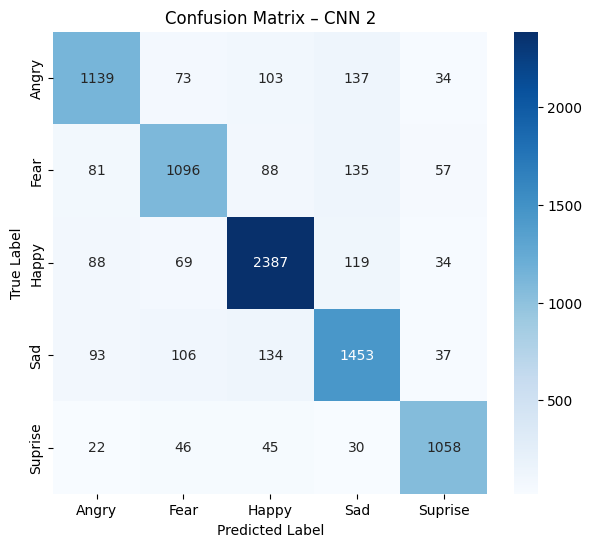

In [40]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – CNN 2")
plt.savefig("og_cnn_confusion_matrix.png")
plt.show()

### Residual CNN: Mini-ResNet

In [17]:
def residual_block(x, filters):
    shortcut = x

    x = tf.keras.layers.Conv2D(filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters: # if filters don't mach
        shortcut = tf.keras.layers.Conv2D(filters, 1, padding="same")(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.Add()([shortcut, x])
    x = tf.keras.layers.ReLU()(x)

    return x

In [18]:
def build_mini_resnet(num_classes=5):
    inputs = tf.keras.Input(shape=(48, 48, 1))

    x = tf.keras.layers.Conv2D(32, 3, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = residual_block(x, 32) # 32 filters
    x = tf.keras.layers.MaxPooling2D()(x)  # -> 24×24

    x = residual_block(x, 64)
    x = tf.keras.layers.MaxPooling2D()(x)  # -> 12×12

    x = residual_block(x, 128)
    x = tf.keras.layers.MaxPooling2D()(x)  # -> 6×6

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)



In [19]:
model_resnet = build_mini_resnet(num_classes=5)
model_resnet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 48, 48,    │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 48, 48,    │      9,248 │ re_lu_8[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 48, 48,    │      9,248 │ re_lu_9[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 48, 48,    │          0 │ re_lu_8[0][0],    │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 48, 48,    │          0 │ add_4[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 24, 24,    │          0 │ re_lu_10[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 24, 24,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 24, 24,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 24, 24,    │      2,112 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 24, 24,    │     36,928 │ re_lu_11[0][0]  

 Total params: 899,397 (3.43 MB)

 Trainable params: 898,053 (3.43 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [ ]:
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy", # loss function for integer labels (not ohe)
    metrics=["accuracy"]
)


In [21]:
history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[callback]
)

Epoch 1/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 129s 394ms/step - accuracy: 0.2841 - loss: 2.4692 - val_accuracy: 0.4331 - val_loss: 1.3889
Epoch 2/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 130s 413ms/step - accuracy: 0.3876 - loss: 1.3821 - val_accuracy: 0.5091 - val_loss: 1.2342
Epoch 3/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 142s 449ms/step - accuracy: 0.4672 - loss: 1.2578 - val_accuracy: 0.5354 - val_loss: 1.1492
Epoch 4/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 127s 401ms/step - accuracy: 0.4968 - loss: 1.1959 - val_accuracy: 0.5624 - val_loss: 1.0738
Epoch 5/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 124s 393ms/step - accuracy: 0.5113 - loss: 1.1439 - val_accuracy: 0.5824 - val_loss: 1.0166
Epoch 6/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 125s 397ms/step - accuracy: 0.5322 - loss: 1.0956 - val_accuracy: 0.5679 - val_loss: 1.0269
Epoch 7/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 124s 394ms/step - accuracy: 0.5456 - loss: 1.0714 - val_accuracy: 0.5468 - val_loss: 1.0856
Epoch 8/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 125s 394ms/step - accuracy: 0.5448 -

In [22]:
test_loss, test_acc = model_resnet.evaluate(test_ds)
print("Final Test Accuracy:", test_acc)

68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.6478 - loss: 0.8285
Final Test Accuracy: 0.6442751884460449


In [23]:
model_resnet.save('cnn_resnet.keras')

In [ ]:
with open("training_history/history_cnn_resnet.pkl", "wb") as f:
    pickle.dump(history_resnet.history, f)

### Tuned resnet

In [ ]:
def build_mini_resnet_2():
    inputs = tf.keras.Input(shape=(48, 48, 1))
    # Stem
    x = tf.keras.layers.Conv2D(32, 3, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Residual blocks
    x = residual_block(x, 32)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = residual_block(x, 64)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = residual_block(x, 128)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)     # instead of Flatten()

    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    outputs = tf.keras.layers.Dense(5, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)

In [26]:
model_resnet_tuned = build_mini_resnet_2()
model_resnet_tuned.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 48, 48,    │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 48, 48,    │      9,248 │ re_lu_15[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 48, 48,    │      9,248 │ re_lu_16[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        128 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 48, 48,    │          0 │ re_lu_15[0][0],   │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 48, 48,    │          0 │ add_7[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 24, 24,    │          0 │ re_lu_17[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 24, 24,    │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 24, 24,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 24, 24,    │      2,112 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 24, 24,    │     36,928 │ re_lu_18[0][0]  

 Total params: 344,133 (1.31 MB)

 Trainable params: 342,277 (1.31 MB)

 Non-trainable params: 1,856 (7.25 KB)

In [ ]:
model_resnet_tuned.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [33]:
callback_2 = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True
)

In [34]:
history_resnet_tuned = model_resnet_tuned.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[callback_2]
)

Epoch 1/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 118s 360ms/step - accuracy: 0.3485 - loss: 1.6204 - val_accuracy: 0.3806 - val_loss: 1.5401
Epoch 2/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 116s 367ms/step - accuracy: 0.5524 - loss: 1.1172 - val_accuracy: 0.3600 - val_loss: 2.1690
Epoch 3/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 116s 366ms/step - accuracy: 0.6318 - loss: 0.9320 - val_accuracy: 0.5141 - val_loss: 1.4206
Epoch 4/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 118s 372ms/step - accuracy: 0.6867 - loss: 0.7983 - val_accuracy: 0.6474 - val_loss: 1.0007
Epoch 5/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 145s 381ms/step - accuracy: 0.7399 - loss: 0.6785 - val_accuracy: 0.5825 - val_loss: 1.2367
Epoch 6/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 121s 383ms/step - accuracy: 0.7916 - loss: 0.5563 - val_accuracy: 0.5514 - val_loss: 1.4117
Epoch 7/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 121s 383ms/step - accuracy: 0.8384 - loss: 0.4436 - val_accuracy: 0.6958 - val_loss: 1.0830
Epoch 8/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 122s 386ms/step - accuracy: 0.8872 -